# OpenIntro Statistics - Chapter 1 : Introduction to Data (Introduction aux données)
## Titanic Survival Analysis (Titanic dataset)
>**Source**: *OpenIntro Statistics*(4th ed.)<br>
>**Core Principle**:*'Variable type determines analysis method'*<br>
[OpenIntro Ch 1 Theory summary](../references/openintro_ch1_summary_md.md)


In [ ]:
# Data loading and Initial Inspection.
# • Observation = line/ligne/行 (如: 一名乘客--un case)
# • Variable = column/列 (如: age, sex)
# • Categorical: nominal(sex/性别) / ordinal(pclass/舱位)
# • Numerical: discrete(sibsp--only integer-0,4,2) / continuous(age--float--1.5)
# • Response Y = survived | Explanatory X = pclass, sex, age
# Observational studies → Association ≠ Causation (cannot prove that "buying first class resulted in survival"

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Load built-in Titanic dataset
df = sns.load_dataset('titanic')

print("*"*70)
print("Step 1.Check dataset (dimension, shape)") 
print("*"*70)
print(f"Dimension of titanic dataset: {df.ndim}") # savoi
print(f"Observations of titanic dataset: {df.shape[0]:,} passengrs")
print(f"Variables of titanic dataset: {df.shape[1]:} features")

#create a report(dataframe) for all details of coloumns.
dtype_report = pd.DataFrame({
    'Column': df.columns,
    'Dtype': [df[col].dtype for col in df.columns],
    'Role': ['Response (Y)' if col == 'survived' else 'Explanatory (X)' for col in df.columns],
    'Unique Values': [df[col].nunique() for col in df.columns],
    'Unique Sample (first 5)': [  #based on the unique value to verify the variable type.
        # get the first five unique values.
        ', '.join(
            str(v) for v in df[col].dropna().unique()[:5]
        ) if df[col].notna().any() else '[]'  # null for this column=every row is null for this column.
        for col in df.columns
    ],
    'Missing %': [
        (df[col].isnull().sum() / len(df) * 100).round(1) 
        for col in df.columns
    ]
})
#config report for output.
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)
print("\nReport for all the columns")
print(dtype_report.to_string(index=False))
print(f"\nShow the first three lines")
display(df.head(3))

**********************************************************************
step 1.Check dataset (dimension, shape)
**********************************************************************
Dimension of titanic dataset: 2
Observations of titanic dataset: 891 passengrs
Variables of titanic dataset: 15 features

Report for all the columns
     Column    Dtype            Role  Unique Values            Unique Sample (first 5)  Missing %
   survived    int64    Response (Y)              2                               0, 1        0.0
     pclass    int64 Explanatory (X)              3                            3, 1, 2        0.0
        sex   object Explanatory (X)              2                       male, female        0.0
        age  float64 Explanatory (X)             88       22.0, 38.0, 26.0, 35.0, 54.0       19.9
      sibsp    int64 Explanatory (X)              7                      1, 0, 3, 4, 2        0.0
      parch    int64 Explanatory (X)              7                      0, 1, 2,

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True


In [2]:
# OpenIntro Ch 1: Variable Type Classification
print("*"*70)
print("Step 2: Variable Type Classification")
print("*"*70)
print("OpenIntro Principle: 'Variable type determines analysis method'\n")

#create a new list for the variable type report.
list_numerical_discrete=[]
list_numerical_continuous=[]
list_categorical_binary=[]
list_categorical_nominal=[]
list_categorical_ordinal=[]
for _, row in dtype_report.iterrows():
    col = row['Column']
    dtype = str(row['Dtype'])
    n_unique = row['Unique Values']
    if col in ['survived','sex','adult_male','alive','alone']: # two values for these columns, so they are categorical binary.
        list_categorical_binary.append(col)
    elif col in ['pclass','class']:  # we can compare with their values, so they are categorical-ordinal.
        list_categorical_ordinal.append(col)
    elif col in ['embarked','embark_town','who','deck']: # we cannot compare them, so they are categorical norminal.
        list_categorical_nominal.append(col)
    elif col in ['sibsp','parch']:  # they are integer, so discrete.
        list_numerical_discrete.append(col)
    elif col in ['age','fare']: # they are float, so continuous.
        list_numerical_continuous.append(col)
#create a dictionary for variable classification.
dict_variable_classification = {
    'categorical-binary':list_categorical_binary,
    'categorical-ordinal':list_categorical_ordinal,
    'categorical-nominal':list_categorical_nominal,
    'numerical-discrete':list_numerical_discrete,
    'numerical-continuous':list_numerical_continuous
}
#output the result of classifiation.
print("Variable classification (OpenIntro Statistics Ch 1.2)")
for key, value in dict_variable_classification.items():
    print(f"{key} : {value}")

**********************************************************************
step 2: Variable Types (classify)
**********************************************************************
OpenIntro Principle: 'Variable type determines analysis method'

Variable classification (OpenIntro Statistics Ch 1.2)
categorical-binary : ['survived', 'sex', 'adult_male', 'alive', 'alone']
categorical-ordinal : ['pclass', 'class']
categorical-nominal : ['embarked', 'who', 'deck', 'embark_town']
numerical-discrete : ['sibsp', 'parch']
numerical-continuous : ['age', 'fare']


**********************************************************************
Step 3: Visualization for Observations and Variables distribution.
**********************************************************************


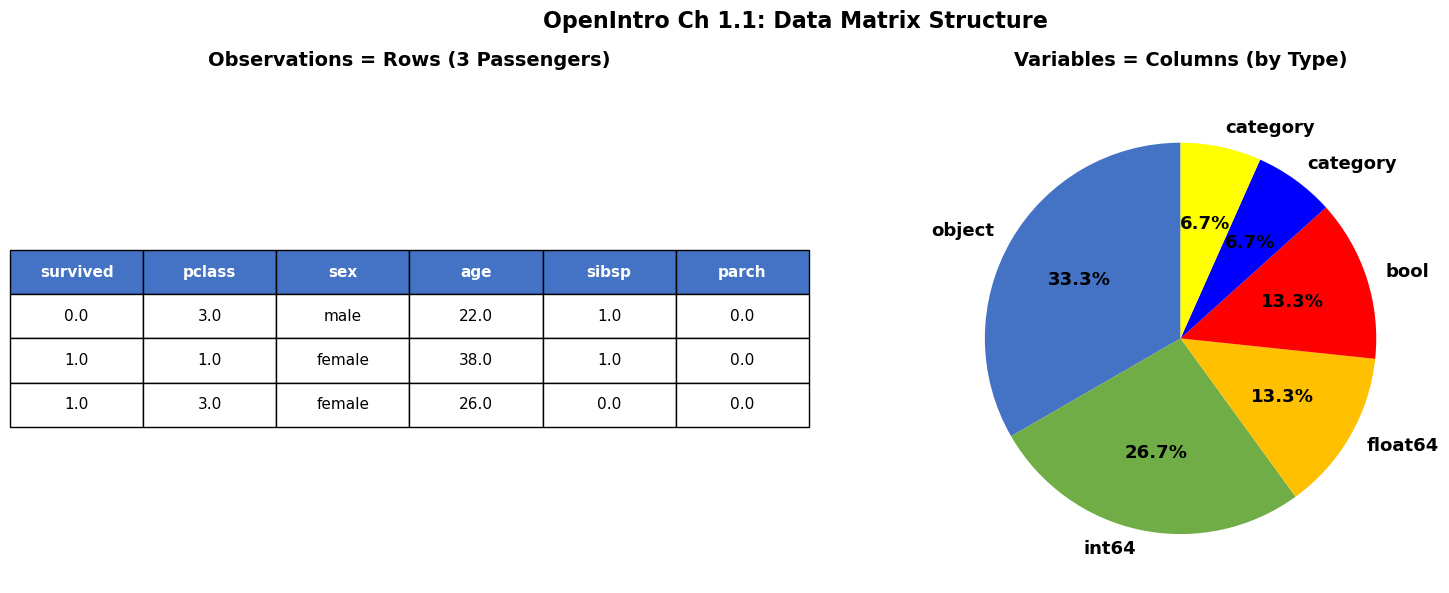


Key Takeaway:
  • Each ROW = One observation (one passenger)
  • Each COLUMN = One variable (one characteristic)
  • Analysis starts with understanding this structure!


In [22]:
# Observations vs Variables Visualization
import os
print("*"*70)
print("Step 3: Visualization for Observations and Variables distribution.")
print("*"*70)
#for save image.
os.makedirs('reports/figures', exist_ok=True)
#Create one screen (fig) with 2 windows (axes)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
#filter = ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch']
# Using this filter, we get a subset of the first three rows.
sample_passengers = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch']].head(3)

#convert all data type to string, the goal is for the table in axes[0]
cell_text = []
for _, row in sample_passengers.iterrows():
    formatted_row = []
    # treate every column in a row --convert to string.
    for col in sample_passengers.columns:
        val = row[col]
        # when numeric, covert numberic to string with one decimal=round(val, 1)
        if pd.api.types.is_numeric_dtype(sample_passengers[col]):
            formatted_row.append(f"{val:.1f}") # val:.1f = round(val,1)
        # when other type (bool,object.category), directly convert to string.
        else:
            formatted_row.append(str(val))
    #keep all the values of one row into cell_text.
    cell_text.append(formatted_row)

# for the first axes. the left image.
axes[0].axis('tight')
axes[0].axis('off')
table = axes[0].table(
    cellText=cell_text,  #the goal for convert all data type to string
    colLabels=sample_passengers.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)
for i in range(len(sample_passengers.columns)):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')
axes[0].set_title('Observations = Rows (3 Passengers)', 
                  fontsize=14, fontweight='bold', pad=20)

# for the right image. Distribution of variable types
type_counts = dtype_report['Dtype'].value_counts()
colors = ['#4472C4', '#70AD47', '#FFC000','red','blue','yellow']
axes[1].pie(
    type_counts.values, 
    labels=type_counts.index, 
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 13, 'weight': 'bold'}
)
axes[1].set_title('Variables = Columns (by Type)', 
                  fontsize=14, fontweight='bold', pad=20)

plt.suptitle('OpenIntro Ch 1.1: Data Matrix Structure', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
output_path = os.path.join(os.getcwd(), 'reports', 'figures', 'ch1_observations_vs_variables.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print("\nKey Takeaway:")
print("  • Each ROW = One observation (one passenger)")
print("  • Each COLUMN = One variable (one characteristic)")
print("  • Analysis starts with understanding this structure!")


**********************************************************************
Step 4: Variable response (Y) vs variables explanatary (X)
**********************************************************************

✅ SUCCESS: Saved to C:\Users\Utilisateur\Data_Science_learn\titanic-statistical-analysis\notebooks\reports\figures\ch1_response_vs_explanatory.png


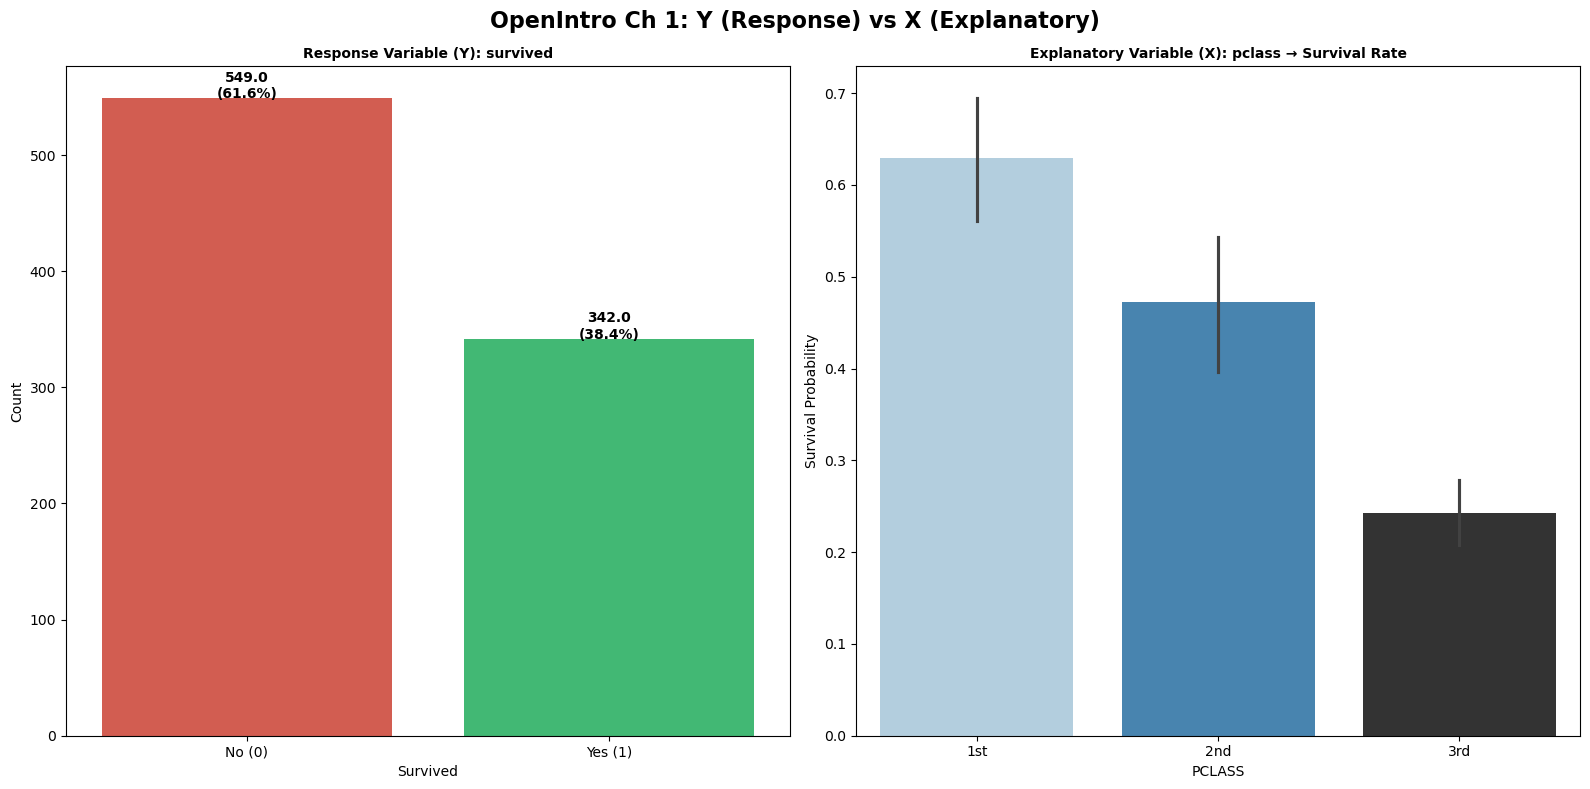


📌 Critical Principle (OpenIntro Ch 1.3):
  • Response Variable (Y): What we want to predict → 'survived'
  • Explanatory Variables (X): What we use to predict → sex, pclass, age, ...
  • NEVER reverse this relationship in analysis!


In [21]:
# OpenIntro Ch 1: Response vs Explanatory Variables
print("*"*70)
print("Step 4.1: Variable response (Y) vs variables explanatary (X)")
print("*"*70)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from matplotlib.ticker import FixedLocator

#for save image
os.makedirs('reports/figures', exist_ok=True)
#list of explanatory Variables
key_vars = ['sex','pclass','age','fare']

n_vars=len(key_vars)
#two image in the same line.
n_cols = 2
#calculate row - floor division
n_row = (n_vars + n_cols - 1) //n_cols

#define canvas with dynamic values. 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
axes = axes.flatter()

#left image, response(y) distribution
sns.countplot(
    data=df, 
    x='survived', 
    hue='survived',  # hue=x
    palette=['#E74C3C', '#2ECC71'], 
    ax=axes[0],
    legend=False  # Hidden Redundant Legend
)

axes[0].set_title('Response Variable (Y): survived', fontsize=10, fontweight='bold')
axes[0].set_xlabel('Survived', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].xaxis.set_major_locator(FixedLocator([0, 1]))
axes[0].set_xticklabels(['No (0)', 'Yes (1)'])

# use FixedLocator to avoid scale warnings
axes[0].xaxis.set_major_locator(FixedLocator([0, 1]))  # Fixed scale position
axes[0].set_xticklabels(['No (0)', 'Yes (1)'])  # Safely set labels now

total = len(df)
for p in axes[0].patches:
    height = p.get_height() 
    axes[0].text(
        p.get_x() + p.get_width()/2., height ,
        f'{height}\n({height/total*100:.1f}%)',
        ha='center', fontsize=10, fontweight='bold'
    )

#for right image : relationship between response(y)=survival and Explanatory(x)=pclass
key_vars = ['sex', 'pclass']
var = 'pclass'  # select only pclass for display选择一个变量展示（可循环展示多个）

# 修复1: 使用 hue=var + legend=False
sns.barplot(
    data=df, 
    x=var, 
    y='survived', 
    hue=var,  # ✅ 关键修复
    palette='Blues_d' if var=='pclass' else 'Set2',
    ax=axes[1],
    legend=False,  # ✅ 隐藏冗余图例
    order=[1, 2, 3] if var=='pclass' else ['female', 'male']
)

axes[1].set_title(f'Explanatory Variable (X): {var} → Survival Rate', 
                  fontsize=10, fontweight='bold')
axes[1].set_ylabel('Survival Probability', fontsize=10)
axes[1].set_xlabel(var.upper(), fontsize=10)

# 修复2: 固定刻度位置
if var == 'pclass':
    axes[1].xaxis.set_major_locator(FixedLocator([0, 1, 2]))  # 3个刻度位置
    axes[1].set_xticklabels(['1st', '2nd', '3rd'])

plt.suptitle('OpenIntro Ch 1: Y (Response) vs X (Explanatory)', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()

# 安全保存（使用绝对路径避免 FileNotFoundError）
output_path = os.path.join(os.getcwd(), 'reports', 'figures', 'ch1_response_vs_explanatory.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n✅ SUCCESS: Saved to {output_path}")
plt.show()

print("\n📌 Critical Principle (OpenIntro Ch 1.3):")
print("  • Response Variable (Y): What we want to predict → 'survived'")
print("  • Explanatory Variables (X): What we use to predict → sex, pclass, age, ...")
print("  • NEVER reverse this relationship in analysis!")

✅ STEP 4: 响应变量 (Y) vs 多个解释变量 (X) — NO WARNINGS

✅ SUCCESS: Saved to C:\Users\Utilisateur\Data_Science_learn\titanic-statistical-analysis\notebooks\reports\figures\ch1_response_vs_multiple_explanatory.png


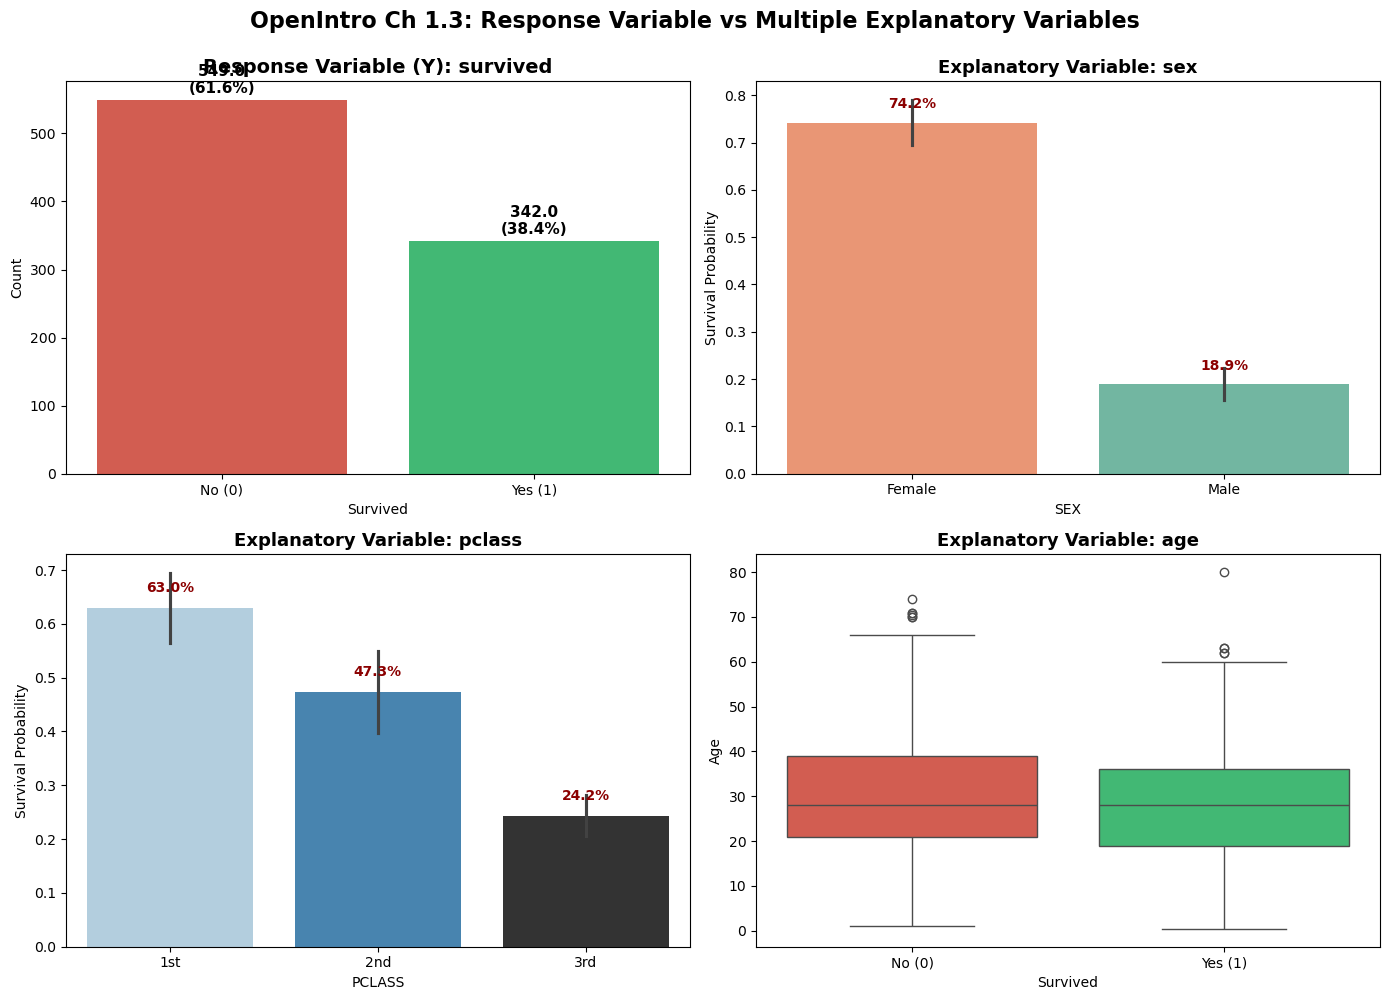


📌 Insights (OpenIntro Ch 1.3):
  • sex: Females had much higher survival rate (~74% vs ~19%)
  • pclass: 1st class passengers had highest survival (~63%)
  • age: Children (<12) had higher survival (visible in box plot)
  • fare: Higher fare → higher survival (proxy for socioeconomic status)


In [24]:
# OpenIntro Ch 1: Multiple Explanatory Variables Visualization
print("*"*70)
print("Step 4.2: Variable response (Y) vs variables explanatary (X)")
print("*"*70)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from matplotlib.ticker import FixedLocator

os.makedirs('reports/figures', exist_ok=True)

#create a list for variables explanatary.
key_vars = ['sex', 'pclass', 'age', 'fare']

# define the value for canvas.
n_vars = len(key_vars)
#two image on the same line.
n_cols = 2
#calculate row.
n_rows = (n_vars + n_cols - 1) // n_cols  # floor division.
#dynamic values for plt.subplots.
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = axes.flatten()

# the first image (row0,column0)--survived distrubtion
sns.countplot(
    data=df, 
    x='survived', 
    hue='survived',  # hue = x
    palette=['#E74C3C', '#2ECC71'], 
    ax=axes[0],
    legend=False  #Hidden Redundant Legend
)
axes[0].set_title('Response Variable (Y): survived', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Count')

# use FixedLocator to avoid scale warnings
axes[0].xaxis.set_major_locator(FixedLocator([0, 1]))
axes[0].set_xticklabels(['No (0)', 'Yes (1)'])

total = len(df)
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(
        p.get_x() + p.get_width()/2., height + 10,
        f'{height}\n({height/total*100:.1f}%)',
        ha='center', fontsize=11, fontweight='bold'
    )

# display all the explanatary
for idx, var in enumerate(key_vars, start=1):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    if var in ['sex', 'pclass']:  # they are categorical variables -> Bar chart
        # sex
        if var == 'sex':
            palette = 'Set2'
            order = ['female', 'male']
            labels = ['Female', 'Male']
        else:  # pclass
            palette = 'Blues_d'
            order = [1, 2, 3]
            labels = ['1st', '2nd', '3rd']
        
        sns.barplot(
            data=df, 
            x=var, 
            y='survived', 
            hue=var,  #hue=pclass or sex
            palette=palette,
            ax=ax,
            order=order,
            legend=False  # ✅ 隐藏冗余图例
        )
        
        # ✅ 修复刻度警告
        ax.xaxis.set_major_locator(FixedLocator(range(len(order))))
        ax.set_xticklabels(labels)
        ax.set_ylabel('Survival Probability')
        ax.set_xlabel(var.upper())
        ax.set_title(f'Explanatory Variable: {var}', fontsize=13, fontweight='bold')
    
    else:  # 连续型变量 → 箱线图 (FIXED)
        # ✅ 关键修复：为 boxplot 添加 hue 参数避免 FutureWarning
        sns.boxplot(
            data=df,
            x='survived',
            y=var,
            hue='survived',  # ✅ 必须配对 hue
            palette=['#E74C3C', '#2ECC71'],
            ax=ax,
            legend=False  # ✅ 隐藏冗余图例
        )
        
        # ✅ 修复刻度警告
        ax.xaxis.set_major_locator(FixedLocator([0, 1]))
        ax.set_xticklabels(['No (0)', 'Yes (1)'])
        ax.set_ylabel(var.capitalize())
        ax.set_xlabel('Survived')
        ax.set_title(f'Explanatory Variable: {var}', fontsize=13, fontweight='bold')
    
    # 添加生存率/统计标签
    if var in ['sex', 'pclass']:
        means = df.groupby(var)['survived'].mean()
        for i, (cat, mean) in enumerate(zip(order, means)):
            ax.text(i, mean + 0.03, f'{mean:.1%}', 
                   ha='center', fontsize=10, fontweight='bold', color='darkred')

# 隐藏未使用的子图
for idx in range(len(key_vars) + 1, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('OpenIntro Ch 1.3: Response Variable vs Multiple Explanatory Variables', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# 安全保存
output_path = os.path.join(os.getcwd(), 'reports', 'figures', 'ch1_response_vs_multiple_explanatory.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\n✅ SUCCESS: Saved to {output_path}")
plt.show()

print("\n📌 Insights (OpenIntro Ch 1.3):")
print("  • sex: Females had much higher survival rate (~74% vs ~19%)")
print("  • pclass: 1st class passengers had highest survival (~63%)")
print("  • age: Children (<12) had higher survival (visible in box plot)")
print("  • fare: Higher fare → higher survival (proxy for socioeconomic status)")